In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

import xgboost

In [402]:
## presets
pd.set_option("display.max_rows", 100)

In [403]:
train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")
var_desc = pd.read_csv("../../data/variabledescription.csv")

In [404]:
## models for predicting certain columns
model_state_dicts = {}

## Functions to preprocess dataframes
    
# ## Function to fill missing values with given model
# def predict_with_model(df, target, feats, model):
#     cols_to_use = feats.copy()
#     cols_to_use.append(target)
#     temp = df[df[cols_to_use].notna().product(1).astype(bool)][cols_to_use]
#     X = temp[feats]
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)
#     y = temp[target]
#     model.fit(X,y)
#     to_pred_bool = (df[feats].notna().product(1) & df[target].isna())
#     df.loc[to_pred_bool, target] = model.predict(scaler.transform(df.loc[to_pred_bool][feats])) 

## Function to fill missing values with given model
def generate_model(df, target, feats, model):
    cols_to_use = feats.copy()
    cols_to_use.append(target)
    temp = df[df[cols_to_use].notna().product(1).astype(bool)][cols_to_use]
    X = temp[feats]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = temp[target]
    model.fit(X,y)
    model_state_dicts[target] = {"model": model, "scaler": scaler}
#     to_pred_bool = (df[feats].notna().product(1) & df[target].isna())
#     df.loc[to_pred_bool, target] = model.predict(scaler.transform(df.loc[to_pred_bool][feats])) 
    
## predict for missing using models
def predict_with_model(df, target, feats):
    scaler = model_state_dicts[target]["scaler"]
    model = model_state_dicts[target]["model"]
    to_pred_bool = (df[feats].notna().product(1) & df[target].isna())
    df.loc[to_pred_bool, target] = model.predict(scaler.transform(df.loc[to_pred_bool][feats])) 
    

    
    
####### FILLING FUNCTION ############
## Function to fill missing in categorical columns
def fill_missing_cat(df, *col_val_pairs):
    for pair in col_val_pairs:
        df[pair[0]].fillna(pair[1], inplace=True)

## Function to fill missing in numeric columns with fixed value 
def fill_missing_num_with_val(df, *col_val_pairs):
    for pair in col_val_pairs:
        df[pair[0]].fillna(pair[1], inplace=True)
        
        
## Function to fill missing with median
def fill_with_median(df, *cols):
    for col in cols:
        df[col].fillna(np.median(df[df[col].notna()][col]), inplace=True)
        
        
## Function to drop rows
def drop_rows_on_inds(df, *inds):
    all_inds = []
    for ind in inds:
        all_inds+=list(ind)
    
    unique_inds = set(all_inds)
    df.drop(unique_inds, inplace=True)

        
####### NEW FEATURE FUNCTIONS ############
## Function to create between feature
def add_days_between(df, begin, end, name):
    df[name] = (pd.to_datetime(df[end]) - pd.to_datetime(df[begin])).dt.days.fillna(0)
    
## Function to separate space separated categoricals into individual features uses `cat_count` function to get counts
def sep_mult_cat(df, *cols):
    for col in cols:
        cat_count(df, col)
        temp = df[col].str.split("\s+")
        uniques = set(temp.sum())
        for unique in uniques:
            col_name = f"{col}_{unique}"
            df[col_name] = temp.apply(lambda x: unique in x) * 1
            
    ## dropping the columns after extraction
    df.drop(list(cols), axis=1, inplace=True)
        
    
## Function to generate count for space separated categories
def cat_count(df, *cols):
    for col in cols:
        new_feat_name = f"{col}_count"
        df[new_feat_name] = df[col].str.split("\s+").apply(len)
        

        
## function to process dataframes
def process_df(df, training):
    df = df.copy()
    ## filling missing categorical features
    fill_missing_cat(df,
                     ("NursDetFactor", "None"),
                     ("TransDetFactor", "None"),
                     ("TransplantingIrrigationPowerSource", "Manual"),
                     ("OrgFertilizers", "None"),
                     ("CropbasalFerts", "Unknown"),
                     ("TransplantingIrrigationSource", "Unknown"),
                     ("PCropSolidOrgFertAppMethod", "None_applied"),
                     ("FirstTopDressFert", "None")
                    )
    ## filling missing numeric values with fixed number
    fill_missing_num_with_val(df,
                              ("StandingWater", 0),
                              ("CropOrgFYM", 0),
                              ("2appDaysUrea", 0),
                              ("2appDaysUrea", 0)
                             )
    
    
    ## generating models for prediction
    if training:
        generate_model(df, "1tdUrea", ["Acre", "BasalDAP", "BasalUrea", "CultLand", "CropCultLand"], LinearRegression())
        generate_model(df, "2tdUrea", ["1tdUrea", "Acre", "BasalDAP"], SVR(C=20))
        generate_model(df, "BasalDAP", ["1tdUrea", "Acre"], SVR(C=15))
        generate_model(df, "BasalUrea", ["BasalDAP", "1tdUrea", "2tdUrea"], LinearRegression())
    
    ## fill missing with model
    predict_with_model(df, "1tdUrea", ["Acre", "BasalDAP", "BasalUrea", "CultLand", "CropCultLand"])
    predict_with_model(df, "2tdUrea", ["1tdUrea", "Acre", "BasalDAP"])
    predict_with_model(df, "BasalDAP", ["1tdUrea", "Acre"])
    predict_with_model(df, "BasalUrea", ["BasalDAP", "1tdUrea", "2tdUrea"])
    
    ## filling some missing values with median
    fill_with_median(df, "SeedlingsPerPit", "TransplantingIrrigationHours", "TransIrriCost", "1tdUrea", "2tdUrea", "BasalDAP",
                    "1appDaysUrea", "BasalUrea", "Harv_hand_rent")
    
    ## feature generation side ##
    
    ## adding days between feaures
    add_days_between(df, "RcNursEstDate", "SeedingSowingTransplanting", "NursToTransDays")
    
    ## adding feature to indicate maintainance of same `MineralFertAppMethod` in first and second doses
    df["MineralFertAppMethodMaintain"] = 0
    df.loc[(df["MineralFertAppMethod.1"] == df["MineralFertAppMethod"]), "MineralFertAppMethodMaintain"] = 1
    
    ## separating columns with space separated categoricals into individual columns (also gets the counts for each feature)
    sep_mult_cat(df, "LandPreparationMethod", "NursDetFactor", "TransDetFactor", "OrgFertilizers", "CropbasalFerts", "FirstTopDressFert")
    
    ## adding area not under cultivation feature
    df["LandNotCult"] = df["CultLand"] - df["CropCultLand"]
    
    ## average `wait in days` before urea application
    df["AvgUreaAppWait"] = (df["1appDaysUrea"] + df["2appDaysUrea"])/2
    
    ## crop tillage depth per land cultivated
    df["CropTillageDepth_per_CropCultLand"] = df["CropTillageDepth"]/df["CropCultLand"]
    
    ## crop tillage depth per available land
    df["CropTillageDepth_per_CultLand"] = df["CropTillageDepth"]/df["CultLand"]
    
    ## Number of days from nursery establishment to crop tillage
    df["NursEstToTillageDays"] = (pd.to_datetime(df["CropTillageDate"]) - pd.to_datetime(df["RcNursEstDate"])).dt.days
    df["NursEstToTillageDays"].fillna(df["NursEstToTillageDays"].mean(), inplace=True)
    
    ## Total amount of urea applied
    df["TotalUrea"] = df["BasalUrea"] + df["1tdUrea"] + df["2tdUrea"]
    
    ## Number of days from nursery establishment to harvest
    df["NursEstToHarvestDays"] = (pd.to_datetime(df["Harv_date"]) - pd.to_datetime(df["RcNursEstDate"])).dt.days
    fill_with_median(df, "NursEstToHarvestDays")
    
    ## Number of days from harvest to Threshing
    df["HarvestToThreshingDays"] = (pd.to_datetime(df["Threshing_date"]) - pd.to_datetime(df["Harv_date"])).dt.days
    
    ## Percentage of product harvested
    df["Harv_perc"] = 100 - df["Residue_perc"]
    
    ## removing rows for columns with have high correlation to yield but outliers
    drop_rows_on_inds(df,
                      df[(df["Acre"] < 1.25) & (df["Yield"] > 2500)].index,
                      df[(df["2tdUrea"] > 50) & (df["Yield"] < 2500)].index,
                      df[(df["BasalDAP"] > 75) & (df["Yield"] < 3000)].index
                     )
    
    ## reducing skew
    df["CultLand"] = np.sqrt(df["CultLand"])
    df["CropCultLand"] = np.sqrt(df["CropCultLand"])
    
    ## dropping columns
    cols_to_drop = ["RcNursEstDate", "Ganaura", "2appDaysUrea", "MineralFertAppMethod.1", "ID"]
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    
    return df

In [405]:
train_processed = process_df(train, True)

In [406]:
train_processed.isna().sum()

District                                        0
Block                                           0
CultLand                                        0
CropCultLand                                    0
CropTillageDate                                 0
CropTillageDepth                                0
CropEstMethod                                   0
SeedingSowingTransplanting                      0
SeedlingsPerPit                                 0
TransplantingIrrigationHours                    0
TransplantingIrrigationSource                   0
TransplantingIrrigationPowerSource              0
TransIrriCost                                   0
StandingWater                                   0
CropOrgFYM                                      0
PCropSolidOrgFertAppMethod                      0
NoFertilizerAppln                               0
BasalDAP                                        0
BasalUrea                                       0
MineralFertAppMethod                            0


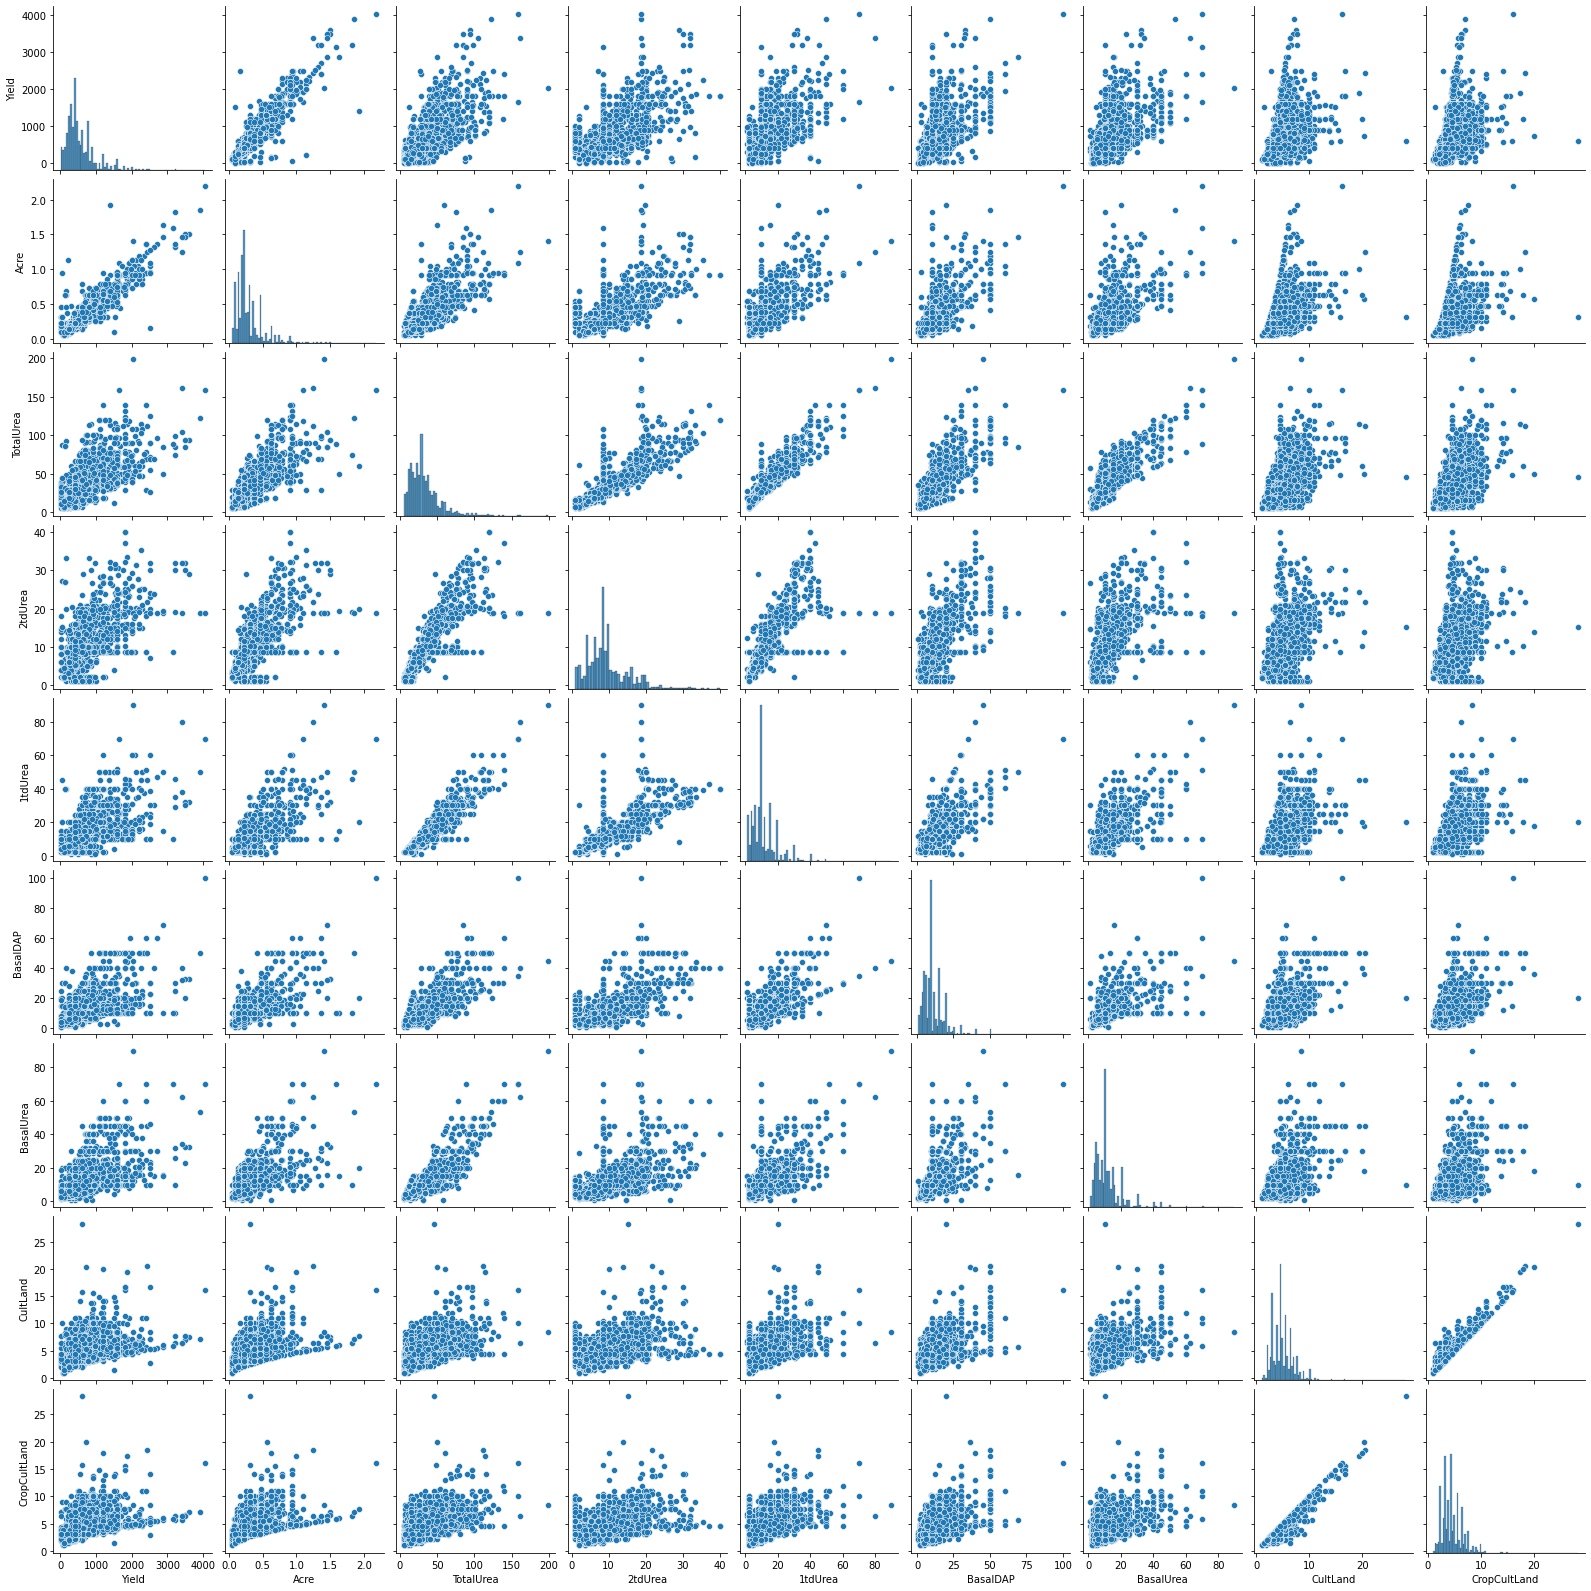

In [407]:
inds = train_processed.select_dtypes("number").corr()["Yield"].sort_values(ascending=False).nlargest(9).index
sns.pairplot(train_processed[inds])
plt.show()

In [408]:
# sns.displot(train_processed["Acre"], kind="kde")
# inds = train_processed[(train_processed["Acre"] < 1.2) & (train_processed["Yield"] > 2500)].index
# train_processed.drop(set(inds)).shape

# inds = train_processed[(train_processed["2tdUrea"] > 50) & (train_processed["Yield"] < 2500)].index
# train_processed.drop(set(inds)).shape

# inds = train_processed[(train_processed["BasalDAP"] > 75) & (train_processed["Yield"] < 3000)].index
# train_processed.drop(set(inds)).shape

inds = train_processed[(train_processed["CultLand"] > 400) & (train_processed["Yield"] < 3000)].index
train_processed.drop(set(inds)).shape

(3845, 90)

In [409]:
np.sqrt(train_processed["CropCultLand"]).corr(train_processed["Yield"])

0.48609669954045254

In [410]:
train_processed.select_dtypes("number").corr()["Yield"].sort_values(ascending=False)

Yield                                           1.000000
Acre                                            0.924482
TotalUrea                                       0.690110
2tdUrea                                         0.645550
1tdUrea                                         0.635468
BasalDAP                                        0.622325
BasalUrea                                       0.591687
CultLand                                        0.470928
CropCultLand                                    0.467771
TransIrriCost                                   0.268006
CropbasalFerts_NPKS                             0.263089
CropOrgFYM                                      0.254480
Harv_hand_rent                                  0.229693
NursEstToHarvestDays                            0.198930
NursEstToTillageDays                            0.190387
FirstTopDressFert_NPKS                          0.169567
LandNotCult                                     0.165940
Residue_perc                   

In [360]:
train_processed["CultLand"].

0       45
1       26
2       10
3       15
4       60
        ..
3865    28
3866     5
3867    50
3868    20
3869     4
Name: CultLand, Length: 3845, dtype: int64

In [7]:
rs = 132
kf = KFold(n_splits = 5, shuffle=True, random_state=rs)

In [8]:
## training model for `TransIrriCost`
temp_target = "Harv_hand_rent"
cols_to_use = ["2tdUrea", temp_target]
temp = train[train[cols_to_use].notna().product(1).astype(bool)][cols_to_use]
temp_X = temp[cols_to_use[:-1]]
## standard scaling
temp_X = StandardScaler().fit_transform(temp_X)
temp_y = temp[temp_target]

In [9]:
res = cross_val_score(SVR(C=65), temp_X, temp_y, cv=kf, scoring="r2")
res.mean()

0.42469995138616784

In [10]:
temp_params = {
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.005, 0.001],
    "max_depth": [2,4,6,8]
}
temp_grid = GridSearchCV(xgboost.XGBRegressor(), temp_params, cv = kf, scoring="r2")
temp_grid.fit(temp_X, temp_y)

C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

GridSearchCV(cv=KFold(n_splits=5, random_state=132, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    int...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.005, 0.001],
                         'max_depth': [2, 4, 6, 8],
                         'n_estimators': [100, 500, 1000]},
             scoring='r2')

In [11]:
print(temp_grid.best_score_)
print(temp_grid.best_params_)

0.49247143408363253
{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 1000}


In [12]:
# predict_with_model(train, "1tdUrea", ["Acre", "BasalDAP", "BasalUrea", "CultLand", "CropCultLand"], LinearRegression())

In [13]:
train["1tdUrea"].isna().sum()

556

In [14]:
(train[["1tdUrea", "Acre"]].notna().product(1) & train["BasalDAP"].isna()).sum()

400

In [87]:
train[["Harv_hand_rent","2tdUrea"]].notna().product(1).sum()

1142